# <div align="center"><b> Desafio 4 - Procesamiento del lenguaje Natural - CEIA </b></div>


<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/ceia-nlp/ceia-nlp/Desafio%204.ipynb">Desafio 4</a></font></small></em> </div>


---


In [1]:
# Descargamos la carpeta con archivos auxiliares (Colab)
# %pip install gdown
# !gdown https://drive.google.com/drive/folders/1hNPqr6g3opu9u-UwnngVcyxUUzfmKZdT?usp=sharing --folder

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>


<div align="center"><img src="./resources/Desafio_4_portada.jpeg" width="600" alt="Figura 1: A data scientist is sitting in front of a computer screen, which is the focal point of the image. The lighting is dark and moody, with a blue hue. The computer screen displays a visualization of a QA bot. The bot and the scientist are chatting with each other, with the bot's responses appearing on the screen. - Generada con Microsoft Image generator"></div>

<div align="center"><small><em>Figura 1: A data scientist is sitting in front of a computer screen, which is the focal point of the image. The lighting is dark and moody, with a blue hue. The computer screen displays a visualization of a QA bot. The bot and the scientist are chatting with each other, with the bot's responses appearing on the screen. - Generada con Microsoft Image generator</em></small></div>


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Desafío 4 - NLP - FIUBA               |
| --------------- | ------------------------------------- |
| **Descrpción**  | BOT QA                                |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com) |

</div>


✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋


In [38]:
import os, json, re, random, logging, pickle, requests, zipfile, gzip, shutil
import gdown
from pathlib import Path
import urllib.request
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [3]:
RANDOM_SEED = 42
DATA_URL = "http://convai.io/data/data_volunteers.json"
LOCAL_FILENAME = "./resources/data_volunteers.json"
LABEL_SOS = "<sos> "
LABEL_EOS = " <eos>"
# En los filtros no incluimos los simbolos <>, dado que están en nuestros labels especiales.
FILTERS = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'

# Glove embeddings
DRIVE_GLOVE_URL = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
GLOVE_EMBEDDINGS_PICKLE_PATH = 'resources/gloveembedding.pkl'
ORIGINAL_GLOVE_URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_EMBEDDINGS_UNZIP_PATH = 'glove.6B.50d.txt'

# Fasttext embeddings
DRIVE_FASTTEXT_URL = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
FASTTEXT_EMBEDDINGS_PICKLE_PATH = 'resources/fasttextembedding.pkl'
ORIGINAL_FASTTEXT_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
FASTTEXT_EMBEDDINGS_UNZIP_PATH = 'cc.en.300.vec'

PLOT_MODEL_PATH = 'resources/model_plot.png'
PLOT_ENCODER_PATH = 'resources/encoder_plot.png'
PLOT_DECODER_PATH = 'resources/decoder_plot.png'

PATIENCE = 10
MODEL_CHECKPOINT_PATH = 'resources/qa_mode.keras'

random.seed(RANDOM_SEED)

## Consigna del desafío


El objetivo es utilizar datos disponibles del challenge [ConvAI2](http://convai.io/data/) (Conversational Intelligence Challenge 2) de conversaciones en inglés, para convertirlo en un BOT QA para responder preguntas del usuario.

### Parte 1

- Descargar el conjunto y pre-procesarlo.

### Parte 2 

- Realizar el preprocesamiento necesario para obtener:
    - `word2idx_inputs`, `max_input_len`
    - `word2idx_outputs`, `max_out_len`, `num_words_output`
    - `encoder_input_sequences`, `decoder_output_sequences`, `decoder_targets`

### Parte 3

- Utilizar los embeddings de *Glove* o *FastText* para transformar los tokens de entrada en vectores.

### Parte 4

- Entrenar un modelo basado en el esquema *encoder-decoder* utilizando los datos generados en los puntos anteriores.

### Parte 5

- Experimentar el modelo en inferencia.

## Resolución


### Parte 1

> - Descargar el conjunto y pre-procesarlo.

*Cargamos el conjunto:*

In [4]:
try:
    # Verificar si el archivo ya está descargado
    if not os.path.isfile(LOCAL_FILENAME):
        print(f"Archivo no encontrado localmente. Descargando desde {DATA_URL}...")
        urllib.request.urlretrieve(DATA_URL, LOCAL_FILENAME)
        print("Descarga completada.")
    else:
        print("El archivo ya existe localmente.")

    # Cargar el archivo JSON en la variable 'data'
    with open(LOCAL_FILENAME, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("Archivo cargado correctamente.")
except urllib.error.URLError as e:
    print(f"Error al descargar el archivo: {e}")
except FileNotFoundError as e:
    print(f"Error al abrir el archivo: {e}")
except json.JSONDecodeError as e:
    print(f"Error al decodificar el archivo JSON: {e}")
except Exception as e:
    print(f"Se produjo un error inesperado: {e}")

El archivo ya existe localmente.
Archivo cargado correctamente.


*Mostramos los datos descargados:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Función que limpia los textos..</p></font></em>

In [5]:
def clean_text(txt, contractions):
    # Convertimos todo el texto a minúsculas
    txt = txt.lower()
    
    # Reemplazamos contracciones comunes    
    for contraction, full_form in contractions.items():
        txt = txt.replace(contraction, full_form)
    
    # Eliminamos cualquier carácter no alfanumérico (y sustituimos por un espacio)
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt.strip()

*Definimos las abrebiaciones identificadas:*

In [6]:
CONTRACTIONS = {"'d": " had", "'s": " is", "'m": " am", "don't": "do not"}

*Pre-procesamos el texto en sentencias:*

<!-- TODO: Preprocesamiento? -->

In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

for line in data:
    dialog = line["dialog"]
    # Recorremos los diálogos pero limitamos a los pares de (input, respuesta)
    for i in range(len(dialog) - 1):
        # Limpiamos el texto de la "pregunta" y la "respuesta"
        chat_in = clean_text(dialog[i]["text"], CONTRACTIONS)
        chat_out = clean_text(dialog[i + 1]["text"], CONTRACTIONS)

        # Agregamos las etiquetas <eos> y <sos> a las frases de salida
        output_sentence = chat_out + LABEL_EOS
        output_sentence_input = LABEL_SOS + chat_out

        # Añadimos las oraciones limpias a sus respectivas listas
        input_sentences.append(chat_in)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

# Mostramos la cantidad de oraciones procesadas
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 13512


*Chequeamos algunas sentencias:*

In [8]:
# Seleccionamos índices aleatorios
random_indices = random.sample(range(len(input_sentences)), 10)

# Creamos una lista para almacenar los datos
df_data = []

# Recorremos los índices aleatorios y creamos un diccionario para cada uno
for idx in random_indices:
    df_row = {
        "Indice": idx,
        "Input Sentence": input_sentences[idx],
        "Output Sentence": output_sentences[idx],
        "Output Sentence Input": output_sentences_inputs[idx]
    }
    df_data.append(df_row)

# Creamos el DataFrame con los datos
df = pd.DataFrame(df_data)

# Mostramos el DataFrame
display(HTML(df.to_html()))

,Indice,Input Sentence,Output Sentence,Output Sentence Input
0,10476,friday is my favorite i am looking for new job what do you do,business <eos>,<sos> business
1,1824,no friends i have mom and pa,that is sad i am a museum guide <eos>,<sos> that is sad i am a museum guide
2,409,not much i do enjoy sports though,math and sports sounds interesting i am more into food <eos>,<sos> math and sports sounds interesting i am more into food
3,12149,ok what is your purpose,what is your purpose <eos>,<sos> what is your purpose
4,4506,wow u the perfect person who gonna help me to find a hotel job somewhere in west country,i do not know what that means <eos>,<sos> i do not know what that means
5,4012,i do not know what that means,nevermind <eos>,<sos> nevermind
6,3657,i have blue eyes,hello <eos>,<sos> hello
7,2286,yes i did it was nice talking to you,like wise bye <eos>,<sos> like wise bye
8,12066,whats your name,how are you <eos>,<sos> how are you
9,1679,end,what is your favorite thing to do mine is rock <eos>,<sos> what is your favorite thing to do mine is rock


📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>En la etapa de entrenamiento, las sentencias `input sentence` son las que debería tomar el encoder, para producir el estado oculto $(H, C)$. Luego, la entrada del decoder sería este estado oculto + la entrada `output sentence input`, y la salida esperada sería `output sentence`. El proceso de aprendizaje se realiza comparando cada término de la salida auto-regresiva del decoder con la salida esperada, donde el último término termina siendo comparado con el token especial `<eos>`. El error de estas comparaciones (utilizando cross-entropy), es lo que se propaga en toda la red para que esta aprenda dicha representación.</p></font></em>

### Parte 2

> - Realizar el preprocesamiento necesario para obtener:  
    - `word2idx_inputs`, `max_input_len`  
    - `word2idx_outputs`, `max_out_len`, `num_words_output`  
    - `encoder_input_sequences`, `decoder_output_sequences`, `decoder_targets`  

*Primeramente, definimos el vocabulario máximo:*

In [9]:
# Máximo del vocabulario. Es establecimiento puramente de recursos, no significa que se llegue a este máximo.
MAX_VOCAB_SIZE = 8000

*Luego, tokenizamos las palabras de entrada:*

In [10]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
# Convertimos los términos 
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

# Diccionario de palabras a indices.
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

Palabras en el vocabulario: 3908


*Podemos observar la tokenización:*

In [11]:
word2idx_inputs

{'i': 1,
 'you': 2,
 'do': 3,
 'a': 4,
 'what': 5,
 'am': 6,
 'to': 7,
 'is': 8,
 'like': 9,
 'are': 10,
 'jobs': 11,
 'have': 12,
 'for': 13,
 'how': 14,
 'love': 15,
 'that': 16,
 'not': 17,
 'the': 18,
 'my': 19,
 'it': 20,
 'of': 21,
 'your': 22,
 'in': 23,
 'hi': 24,
 'living': 25,
 'and': 26,
 'books': 27,
 'about': 28,
 'oh': 29,
 'work': 30,
 'any': 31,
 'because': 32,
 'good': 33,
 'india': 34,
 'from': 35,
 'normal': 36,
 'ok': 37,
 'yes': 38,
 'no': 39,
 'me': 40,
 'hello': 41,
 'favorite': 42,
 'd': 43,
 'hobbies': 44,
 'read': 45,
 'with': 46,
 'play': 47,
 'just': 48,
 'doing': 49,
 'education': 50,
 'well': 51,
 'cool': 52,
 'so': 53,
 'u': 54,
 'go': 55,
 'music': 56,
 'food': 57,
 'at': 58,
 'fun': 59,
 'but': 60,
 'name': 61,
 'too': 62,
 'lot': 63,
 'great': 64,
 'sleep': 65,
 'where': 66,
 'can': 67,
 'live': 68,
 'movies': 69,
 'time': 70,
 'be': 71,
 'today': 72,
 'kind': 73,
 'nice': 74,
 'know': 75,
 'job': 76,
 'dog': 77,
 'see': 78,
 'cook': 79,
 'r': 80,
 'so

*Y tokenizamos las palabras de salidas (target):*

<!-- TODO: Consultar si es necesario dos tokenizadores. O solamente con uno (con los tokens de fin y inicio agregado ya serviría). Inclusive hacer un fit con todo el corpus. -->

In [12]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=FILTERS)
output_tokenizer.fit_on_texts([str(LABEL_SOS.strip()), str(LABEL_EOS.strip())] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

# Se suma 1 para incluir el token de palabra desconocida
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 

Palabras en el vocabulario: 3888


💡 <em><font color='IndianRed'>Hipótesis:</font></em>
<em><font color='IndianRed'><p>Se define un máximo de sentencias de entrada y de salida respectivamente, comparando con los datos de entrenamiento. Esto es debido a que no tiene sentido generar más tamaño de estas secuencias, ya que serían datos que nunca fueron vistos por el modelo, y se empezaría a perder la coherencia luego de estos máximos.
</p></font></em>

*Luego que tenemos las sentencias, como veremos, tenemos de varios tamaños...*

*Observamos `input_integer_seq`:*

<Axes: ylabel='Count'>

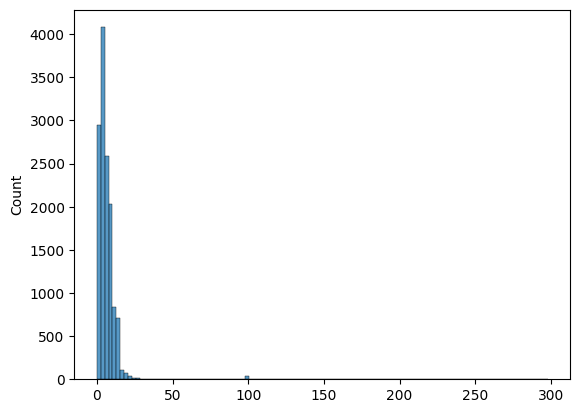

In [13]:
input_integer_seq_lenght = [len(sentence) for sentence in input_integer_seq]
sns.histplot(input_integer_seq_lenght, bins=int(sqrt(len(input_integer_seq_lenght))))

*Podemos observar los valores de la mediana o un percentil (ej:90):*

In [14]:
print(f"Mediana: {np.median(input_integer_seq_lenght)}")
print(f"Percentil 90: {np.percentile(input_integer_seq_lenght, q=90)}")

Mediana: 5.0
Percentil 90: 12.0


*En este punto, podemos definir un tamaño máximo de 9 por ejemplo (sería el aproximadamente el percentil 75):*

In [15]:
max_input_len = 9
print("Máximo tamaño de entrada:", max_input_len)

Máximo tamaño de entrada: 9


💡 <em><font color='IndianRed'>Hipótesis:</font></em>
<em><font color='IndianRed'><p>Este valor definido es un hiperparámetro, el cual se debería tunear, en el sentido de que cuando mayor sea mejor, pero esto significa que habrán menos ejemplos para entrenar el modelo, lo que implica una mayor capacidad de generalización (inclusive sentencias con mucho padding empeoran esta problemática).</p></font></em>

*Observamos `output_integer_seq`:*

<Axes: ylabel='Count'>

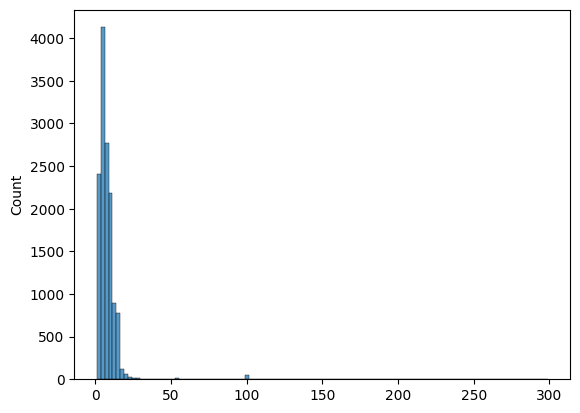

In [16]:
output_integer_seq_lenght = [len(sentence) for sentence in output_integer_seq]
sns.histplot(output_integer_seq_lenght, bins=int(sqrt(len(output_integer_seq_lenght))))

*Observamos los valores de la mediana y el percentil (ej:90):*

In [17]:
print(f"Mediana: {np.median(output_integer_seq_lenght)}")
print(f"Percentil 90: {np.percentile(output_integer_seq_lenght, q=90)}")

Mediana: 7.0
Percentil 90: 13.0


*Definimos un valor máximo de 10 para este caso:*

In [18]:
max_out_len = 10
print("Sentencia de salida más larga:", max_out_len)

Sentencia de salida más larga: 10


*Una vez definidos los valores, filtramos las sentencias, con la condición de filtrar aquellos índices que tanto la entrada como la salida cumplan con la condición de que la cantidad de elementos sea menor a lo establecido.*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Filtra las sentencias según máximos establecidos.</p></font></em>

In [19]:
def filter_sequences(
    input_seq, output_seq, output_input_seq, max_input_len, max_out_len
):
    filtered = [
        (inp, out, out_inp)
        for inp, out, out_inp in zip(input_seq, output_seq, output_input_seq)
        if len(inp) <= max_input_len and len(out) <= max_out_len
    ]
    return map(list, zip(*filtered)) if filtered else ([], [], [])

*Filtramos las setencias:*

In [20]:
input_integer_seq, output_integer_seq, output_input_integer_seq = filter_sequences(
    input_integer_seq,
    output_integer_seq,
    output_input_integer_seq,
    max_input_len,
    max_out_len,
)

*Para finalizar, se realiza padding para completar aquellas sentencias que son menores, con el objetivo de que todas queden del mismo tamaño:*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p> la hora de realizar padding, es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.</p></font></em>

In [21]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences: np.ndarray = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences: np.ndarray = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 9092
encoder_input_sequences shape: (9092, 9)
decoder_input_sequences shape: (9092, 10)


*La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato `oneHotEncoder`. Se utiliza `decoder_output_sequences` con la misma estrategia con que se transformó la entrada del decoder:*

In [22]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(9092, 10, 3889)

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>

O sea, `decoder_targets` tiene una dimensión $(cantSent, cantSeq, vocab)$, donde:
- $cantSent$ $\rightarrow$ Son la cantidad de sentencias a procesar, en este caso, 10885.
- $cantSeq$ $\rightarrow$ Es la cantidad de térmios (tokens) dentro de una sentencia, en este caso, son sentencias de tamaño 10.
- $vocab$ $\rightarrow$ Tamaño del vocabulario + 1 (término OOV).

</p></font></em>

### Parte 3

> Utilizar los embeddings de *Glove* o *FastText* para transformar los tokens de entrada en vectores.

<em><p>

Para descargar los embeddings se puede realizar de la siguiente página:

- Glove: https://nlp.stanford.edu/projects/glove/
- FastText: https://fasttext.cc/docs/en/english-vectors.html

</p></em>

*Inicialmente, tenemos que descargar los embeddings...*

🤖 <em><font color='DarkGoldenRod'>Consulta a IA (ChatGPT 4o):</font></em> 🤖

❔ <em><font color='GoldenRod'>Prompt:</font></em>
<em><font color='GoldenRod'><p>

Podrías realizar el código para descargar unos embeddings de GloVe y FastText? Debe seguir los siguientes pasos:
1 - Chequear que ya no exista el archivo pickle localmente.
2 - Sino existe, intentar descargar desde el Drive (Gdown).
3 - Sino extá disponible el del Drive, descargar desde la URL original. En este caso, se debe descomprimir.

Hacer una función para luego utilizarla para los dos casos.

Estas son las URL y direcciones:

DRIVE_GLOVE_URL = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
GLOVE_EMBEDDINGS_PICKLE_PATH = 'resources/gloveembedding.pkl'
ORIGINAL_GLOVE_URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_EMBEDDINGS_UNZIP_PATH = 'glove.6B.50d.txt'


DRIVE_FASTTEXT_URL = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
FASTTEXT_EMBEDDINGS_PICKLE_PATH = 'resources/fasttextembedding.pkl'
ORIGINAL_FASTTEXT_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
FASTTEXT_EMBEDDINGS_UNZIP_PATH = 'cc.en.300.vec'

</p></font></em>

🔃 <em><font color='BurlyWood'>Respuesta:</font></em>
<em><font color='BurlyWood'><p>

A continuación te proporciono una función que implementa el flujo descrito para descargar embeddings de GloVe y FastText, verificando primero si el archivo ya existe en el sistema local como un archivo pickle, luego intentando descargarlo desde Google Drive si no existe, y finalmente descargándolo desde la URL original y descomprimiéndolo si tampoco está disponible en Drive.

Para manejar las descargas, usaremos gdown para Drive, y requests junto con zipfile y gzip para la descompresión. El código está dividido en una única función para ser reutilizada en ambos casos (GloVe y FastText):

```python
import os
import gdown
import requests
import zipfile
import gzip
import shutil

def descargar_embeddings(pickle_path, drive_url, original_url, unzip_path):
    """
    Función para descargar embeddings si no existe el archivo pickle.
    Primero intenta descargarlo desde Google Drive, y si falla, lo descarga desde la URL original.
    
    :param pickle_path: Ruta local donde se almacenará el archivo pickle.
    :param drive_url: URL de descarga de Google Drive.
    :param original_url: URL original para descargar el archivo comprimido.
    :param unzip_path: Ruta del archivo dentro del zip/gz que se debe extraer.
    """
    if os.path.exists(pickle_path):
        print(f"El archivo pickle ya existe en {pickle_path}. No es necesario descargarlo.")
        return
    
    # Intentar descargar desde Google Drive
    try:
        print(f"Intentando descargar desde Google Drive: {drive_url}")
        gdown.download(drive_url, pickle_path, quiet=False)
        if os.path.exists(pickle_path):
            print(f"Descarga exitosa desde Google Drive: {pickle_path}")
            return
    except Exception as e:
        print(f"Falló la descarga desde Google Drive: {e}")
    
    # Si no existe, intentar descargar desde la URL original
    print(f"Intentando descargar desde la URL original: {original_url}")
    try:
        response = requests.get(original_url, stream=True)
        zip_filename = original_url.split("/")[-1]
        
        with open(zip_filename, 'wb') as f:
            shutil.copyfileobj(response.raw, f)
        
        # Descomprimir si es necesario
        if zip_filename.endswith('.zip'):
            print("Descomprimiendo archivo .zip")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extract(unzip_path)
        elif zip_filename.endswith('.gz'):
            print("Descomprimiendo archivo .gz")
            with gzip.open(zip_filename, 'rb') as f_in:
                with open(unzip_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

        print(f"Archivo descomprimido correctamente en {unzip_path}")

    except Exception as e:
        print(f"Falló la descarga desde la URL original: {e}")

# Uso de la función para GloVe
DRIVE_GLOVE_URL = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
GLOVE_EMBEDDINGS_PICKLE_PATH = 'resources/gloveembedding.pkl'
ORIGINAL_GLOVE_URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_EMBEDDINGS_UNZIP_PATH = 'glove.6B.50d.txt'

descargar_embeddings(GLOVE_EMBEDDINGS_PICKLE_PATH, DRIVE_GLOVE_URL, ORIGINAL_GLOVE_URL, GLOVE_EMBEDDINGS_UNZIP_PATH)

# Uso de la función para FastText
DRIVE_FASTTEXT_URL = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
FASTTEXT_EMBEDDINGS_PICKLE_PATH = 'resources/fasttextembedding.pkl'
ORIGINAL_FASTTEXT_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
FASTTEXT_EMBEDDINGS_UNZIP_PATH = 'cc.en.300.vec'

descargar_embeddings(FASTTEXT_EMBEDDINGS_PICKLE_PATH, DRIVE_FASTTEXT_URL, ORIGINAL_FASTTEXT_URL, FASTTEXT_EMBEDDINGS_UNZIP_PATH)
```

<strong>Explicación del código:</strong>

1. Chequeo local: Primero se verifica si el archivo pickle ya existe localmente.
2. Descarga desde Google Drive: Si no existe el archivo, se intenta descargar usando gdown.
3. Descarga desde la URL original: Si la descarga de Google Drive falla, se intenta descargar desde la URL original usando requests.
4. Descompresión: Dependiendo del tipo de archivo (.zip o .gz), se descomprime usando zipfile o gzip.
5. Reutilización: La misma función descargar_embeddings se puede usar para ambos casos, GloVe y FastText, con diferentes URLs y rutas de archivos.

¡De esta forma tienes una implementación reutilizable y flexible para gestionar las descargas de embeddings!

</p></font></em>

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Función para obtener los embeddings online.</p></font></em>

In [23]:
def descargar_embeddings(pickle_path, drive_url, original_url, unzip_path):
    """
    Función para descargar embeddings si no existe el archivo pickle.
    Primero intenta descargarlo desde Google Drive, y si falla, lo descarga desde la URL original.
    
    :param pickle_path: Ruta local donde se almacenará el archivo pickle.
    :param drive_url: URL de descarga de Google Drive.
    :param original_url: URL original para descargar el archivo comprimido.
    :param unzip_path: Ruta del archivo dentro del zip/gz que se debe extraer.
    """
    if os.path.exists(pickle_path):
        print(f"El archivo pickle ya existe en {pickle_path}. No es necesario descargarlo.")
        return
    
    # Intentar descargar desde Google Drive
    try:
        print(f"Intentando descargar desde Google Drive: {drive_url}")
        gdown.download(drive_url, pickle_path, quiet=False)
        if os.path.exists(pickle_path):
            print(f"Descarga exitosa desde Google Drive: {pickle_path}")
            return
    except Exception as e:
        print(f"Falló la descarga desde Google Drive: {e}")
    
    # Si no existe, intentar descargar desde la URL original
    print(f"Intentando descargar desde la URL original: {original_url}")
    try:
        response = requests.get(original_url, stream=True)
        zip_filename = original_url.split("/")[-1]
        
        with open(zip_filename, 'wb') as f:
            shutil.copyfileobj(response.raw, f)
        
        # Descomprimir si es necesario
        if zip_filename.endswith('.zip'):
            print("Descomprimiendo archivo .zip")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extract(unzip_path)
        elif zip_filename.endswith('.gz'):
            print("Descomprimiendo archivo .gz")
            with gzip.open(zip_filename, 'rb') as f_in:
                with open(unzip_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

        print(f"Archivo descomprimido correctamente en {unzip_path}")

    except Exception as e:
        print(f"Falló la descarga desde la URL original: {e}")

*Descargamos los embeddings:*

In [24]:
descargar_embeddings(GLOVE_EMBEDDINGS_PICKLE_PATH, DRIVE_GLOVE_URL, ORIGINAL_GLOVE_URL, GLOVE_EMBEDDINGS_UNZIP_PATH)
descargar_embeddings(FASTTEXT_EMBEDDINGS_PICKLE_PATH, DRIVE_FASTTEXT_URL, ORIGINAL_FASTTEXT_URL, FASTTEXT_EMBEDDINGS_UNZIP_PATH)

El archivo pickle ya existe en resources/gloveembedding.pkl. No es necesario descargarlo.
El archivo pickle ya existe en resources/fasttextembedding.pkl. No es necesario descargarlo.


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>[Descripción de la función auxiliar...]</p></font></em>

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Clase auxiliar para procesar los embeddings de forma común. Incluye como cargar los embeddings a partir de sus pickles y guardarlos, así como también funciónes para obtener términos dados, índices y viceversa.</p></font></em>

In [25]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), "Words embedding not available"
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings["word"], index))
        self.idx2word = dict(zip(index, self.embeddings["word"]))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]["embedding"]

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, "-1") for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            "loading words embeddings from pickle {}".format(self.PKL_PATH)
        )
        max_bytes = 2**28 - 1  # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, "rb") as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug("words embeddings loaded")
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            "converting and loading words embeddings from text file {}".format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [
            ("word", np.dtype("U" + str(self.WORD_MAX_SIZE))),
            ("embedding", np.float32, (self.N_FEATURES,)),
        ]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(
            self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8"
        ) as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:])
                for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [("null_embedding", np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure,
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1  # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, "wb") as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx : idx + max_bytes])
        self.logger.debug("words embeddings loaded")
        return embeddings


# Armamos clases particulares para manejar los embeddings de Glove y Fasttext
# que heredan de la clase anterior WordsEmbeddings
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = GLOVE_EMBEDDINGS_UNZIP_PATH
    PKL_PATH = GLOVE_EMBEDDINGS_PICKLE_PATH
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = FASTTEXT_EMBEDDINGS_UNZIP_PATH
    PKL_PATH = FASTTEXT_EMBEDDINGS_PICKLE_PATH
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

*Instanciamos los embeddings:*

In [26]:
model_embeddings = GloveEmbeddings()

*Creamos la matriz de embeddings pre-entrenados, que luego le pasaremos como pesos a la capa de embedding de nuestro modelo:*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Esta matriz tendrá solamente aquellas palabras que estén en nuestro vocabulario, dado que el embedding pre-entrenado, fue entrenado con un vocabulario mucho mayor.</p></font></em>

In [27]:
print('Preparing embedding matrix...')
# Dimensión de los vectores de embedding (50 para GloVe en este caso)
embed_dim = model_embeddings.N_FEATURES

# Lista para almacenar palabras no encontradas en el modelo de embeddings.
words_not_found = []

# Número de palabras a incluir, limitado por MAX_VOCAB_SIZE o el tamaño del vocabulario de entrada. En este caso los 3894 de nuestro vocabulario.
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))

embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    word_idx = model_embeddings.words2idxs(word)[0]
    if word_idx != -1:  # La palabra se encontró en el modelo de embeddings
        embedding_vector = model_embeddings.get_words_embeddings(word)[0]
        embedding_matrix[i] = embedding_vector
    else:
        # Palabra no encontrada en el índice de embeddings
        # Se deja como un vector de ceros en embedding_matrix[i]
        words_not_found.append(word)

print('Number of null word embeddings:', np.sum(np.all(embedding_matrix == 0, axis=1)))
print('Words not found:', len(words_not_found))

Preparing embedding matrix...
Number of null word embeddings: 67
Words not found: 66


*Podemos ver cuales palabras no fueron encontradas en nuestro embedding pre-entrenado:*

In [28]:
words_not_found

['1',
 '2',
 '3',
 '18',
 '12',
 '32',
 '5',
 '19',
 '20',
 '22',
 '30',
 '100',
 '33',
 '4',
 '10',
 '17',
 '35',
 '25',
 '24',
 '8',
 '21',
 '80',
 '13',
 '56',
 '14',
 '7',
 '9',
 '40',
 '2011',
 '3rd',
 '26',
 '6',
 '4m',
 '23d',
 '2nd',
 '36',
 '3pm',
 '40k',
 '16',
 '80is',
 '41',
 '100km',
 '2015',
 '8th',
 '60',
 '11th',
 'ൻ',
 'ങ',
 'ൽ',
 '23',
 '386',
 '27',
 '46',
 '43',
 '220',
 '12th',
 '11',
 '20s',
 'भ',
 '10th',
 '3kids',
 '15',
 '54',
 '42',
 '9th',
 '300']

*Finalmente, podemos ver la forma de la matriz de embeddings:*

In [29]:
embedding_matrix.shape

(3908, 50)

### Parte 4

> Entrenar un modelo basado en el esquema *encoder-decoder* utilizando los datos generados en los puntos anteriores.

*Para el entrenamiento, tenemos que definir el $encoder$ y el $decoder$.*

*Primeramente, definimos una función que genere el $Encoder$:*

In [30]:
# Función para crear el encoder
def create_encoder(max_input_len, nb_words, embed_dim, embedding_matrix, n_units):
    # Definir entradas del encoder
    encoder_inputs = Input(shape=(max_input_len,))
    
    # Capa de embeddings del encoder
    encoder_embedding_layer = Embedding(
        input_dim=nb_words,  
        output_dim=embed_dim,  
        input_length=max_input_len,
        weights=[embedding_matrix],  
        trainable=False)
    
    # Pasamos primero por la capa de embeddings.
    encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
    
    # LSTM del encoder
    encoder = LSTM(n_units, return_state=True)

    # Pasamos por la LSTM (esta devuelve la salida y los estados ocultos, la salida no la usamos)
    _, state_h, state_c = encoder(encoder_inputs_x)
    encoder_states = [state_h, state_c]
    
    # Devolvemos los estados ocultos y la entrada.
    return encoder_inputs, encoder_states

*Después, definimos el $Decoder$:*

<!-- TODO: Podríamos utilizar la misma capa de embeddings sin entrenar? -->

In [31]:
# Función para crear el decoder
def create_decoder(max_out_len, num_words_output, encoder_states, n_units):
    # Definir entradas del decoder
    decoder_inputs = Input(shape=(max_out_len,))
    
    # Capa de embeddings del decoder
    decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
    decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
    
    # LSTM del decoder
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
    
    # Capa Dense
    decoder_dense = Dense(num_words_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Devolvemos referencias que luego se utilizarán para crear solo el decoder.
    return decoder_inputs, decoder_outputs, decoder_lstm, decoder_dense, decoder_embedding_layer

*Instanciamos el modelo:*

In [32]:
# Verificamos que todo esté definido.
print(f"max_input_len: {max_input_len}")
print(f'nb_words: {nb_words}')
print(f'embed_dim: {embed_dim}')
print(f'embedding_matrix.shape: {embedding_matrix.shape}')
print(f'max_out_len: {max_out_len}')
print(f'num_words_output: {num_words_output}')

# Cantidad neuronas LSTM
n_units = 128

# Crear encoder y decoder
encoder_inputs, encoder_states = create_encoder(max_input_len, nb_words, embed_dim, embedding_matrix, n_units)
decoder_inputs, decoder_outputs, decoder_lstm, decoder_dense, decoder_embedding_layer = create_decoder(max_out_len, num_words_output, encoder_states, n_units)

# Crear el modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

max_input_len: 9
nb_words: 3908
embed_dim: 50
embedding_matrix.shape: (3908, 50)
max_out_len: 10
num_words_output: 3889


d:\Documentos\Git Repositories\uba-ceia\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 9, 50)     │    195,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 128)   │    497,792 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 3889)  │    501,681 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,418,105 (5.41 MB)

 Trainable params: 1,222,705 (4.66 MB)

 Non-trainable params: 195,400 (763.28 KB)

*Chequeamos gráficamente que el modelo esté correcto:*

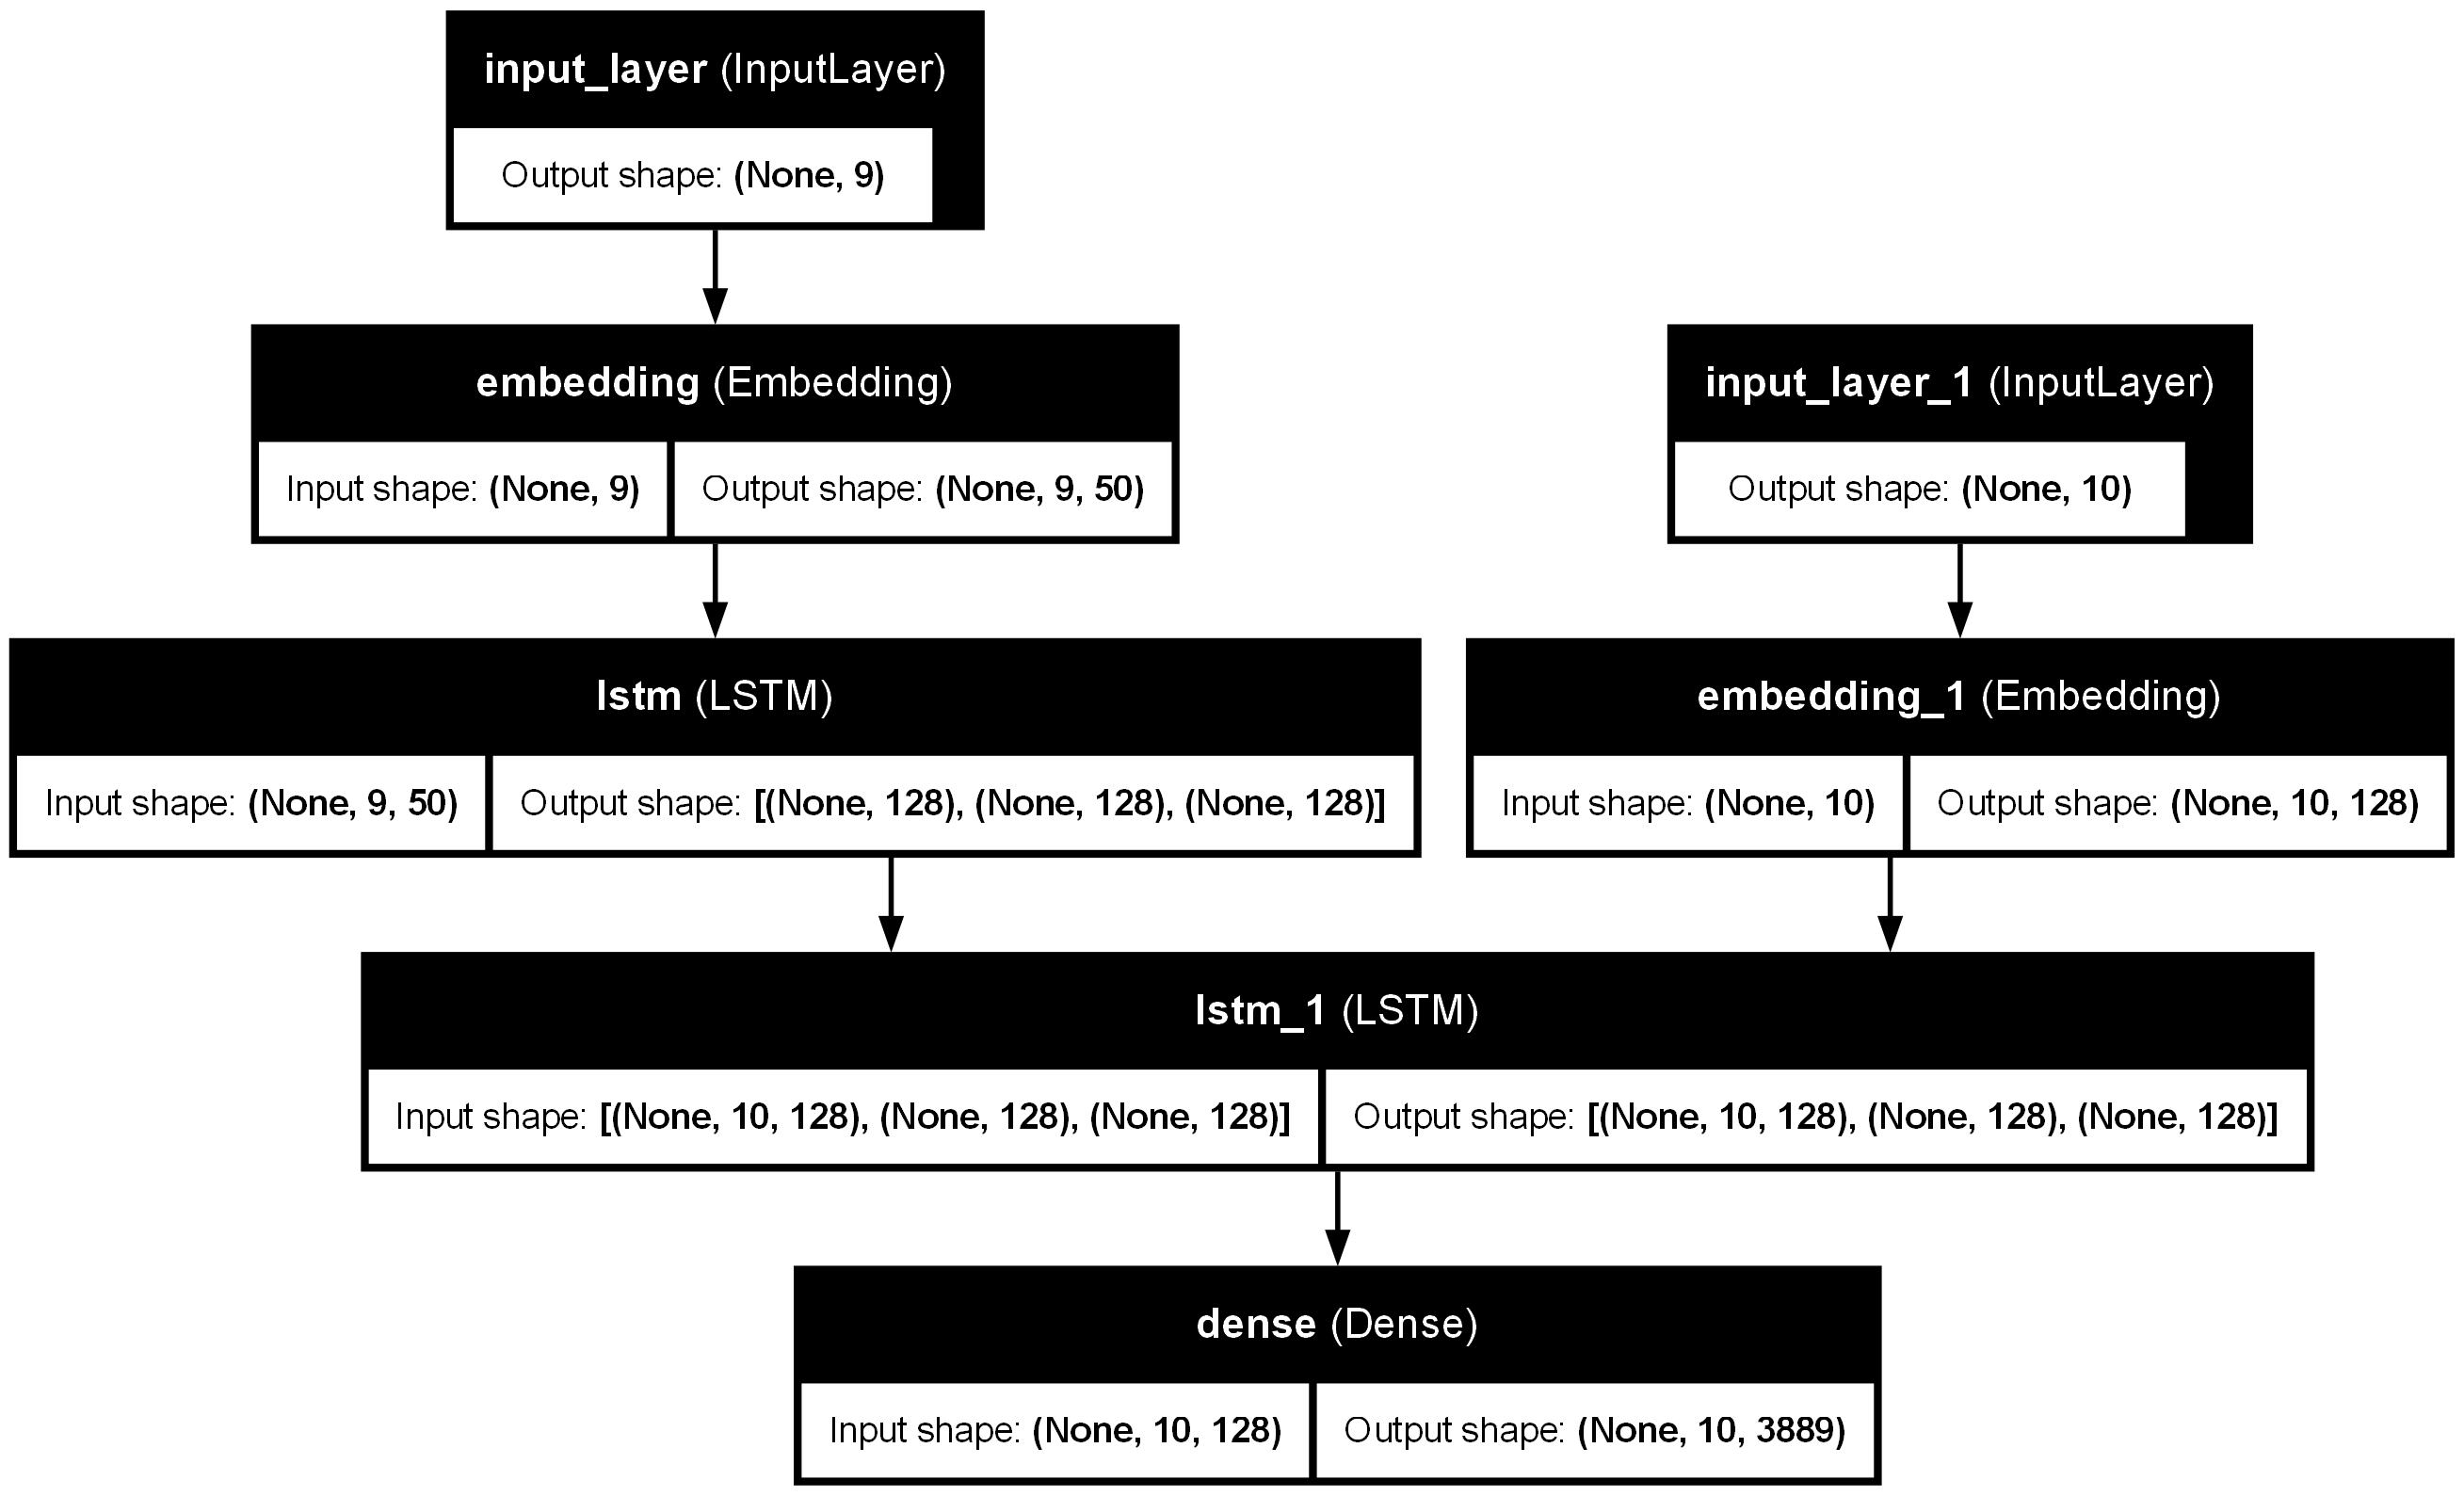

In [33]:
plot_model(model, to_file=PLOT_MODEL_PATH, show_shapes=True, show_layer_names=True)

*Para la inferencia, necesitamos definir los modelos por separado, dado que se utiliza el $Encoder$ una única vez (al principio de la generación) y luego solo el $Decoder$.*

*Definimos una referencia al $Encoder$:*

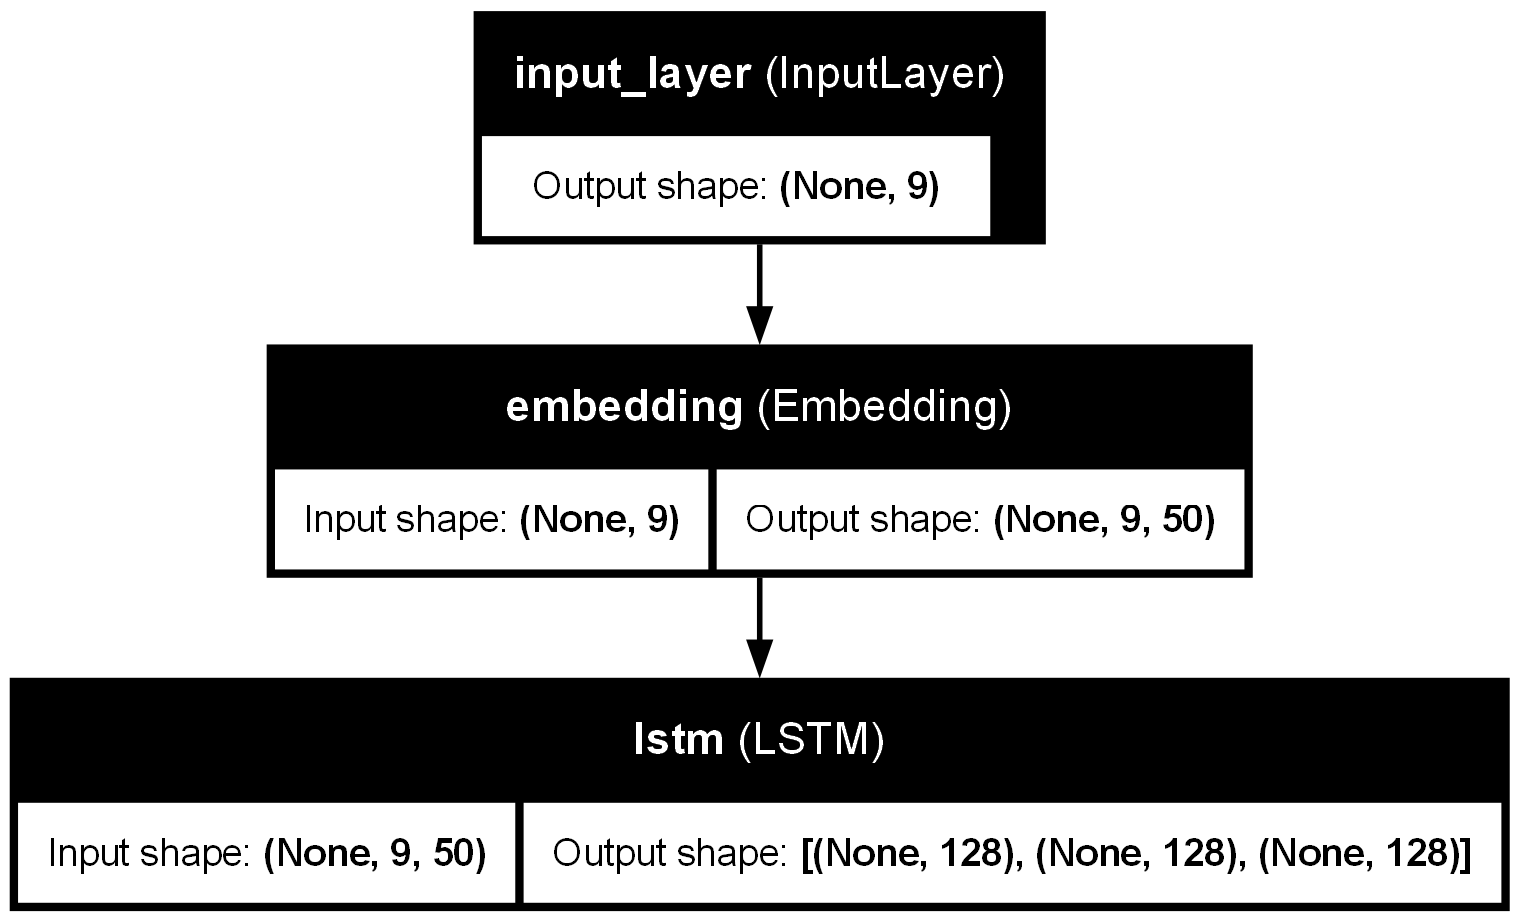

In [34]:
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file=PLOT_ENCODER_PATH, show_shapes=True, show_layer_names=True)

*Definimos el $Decoder$ para realizar la inferencia:*

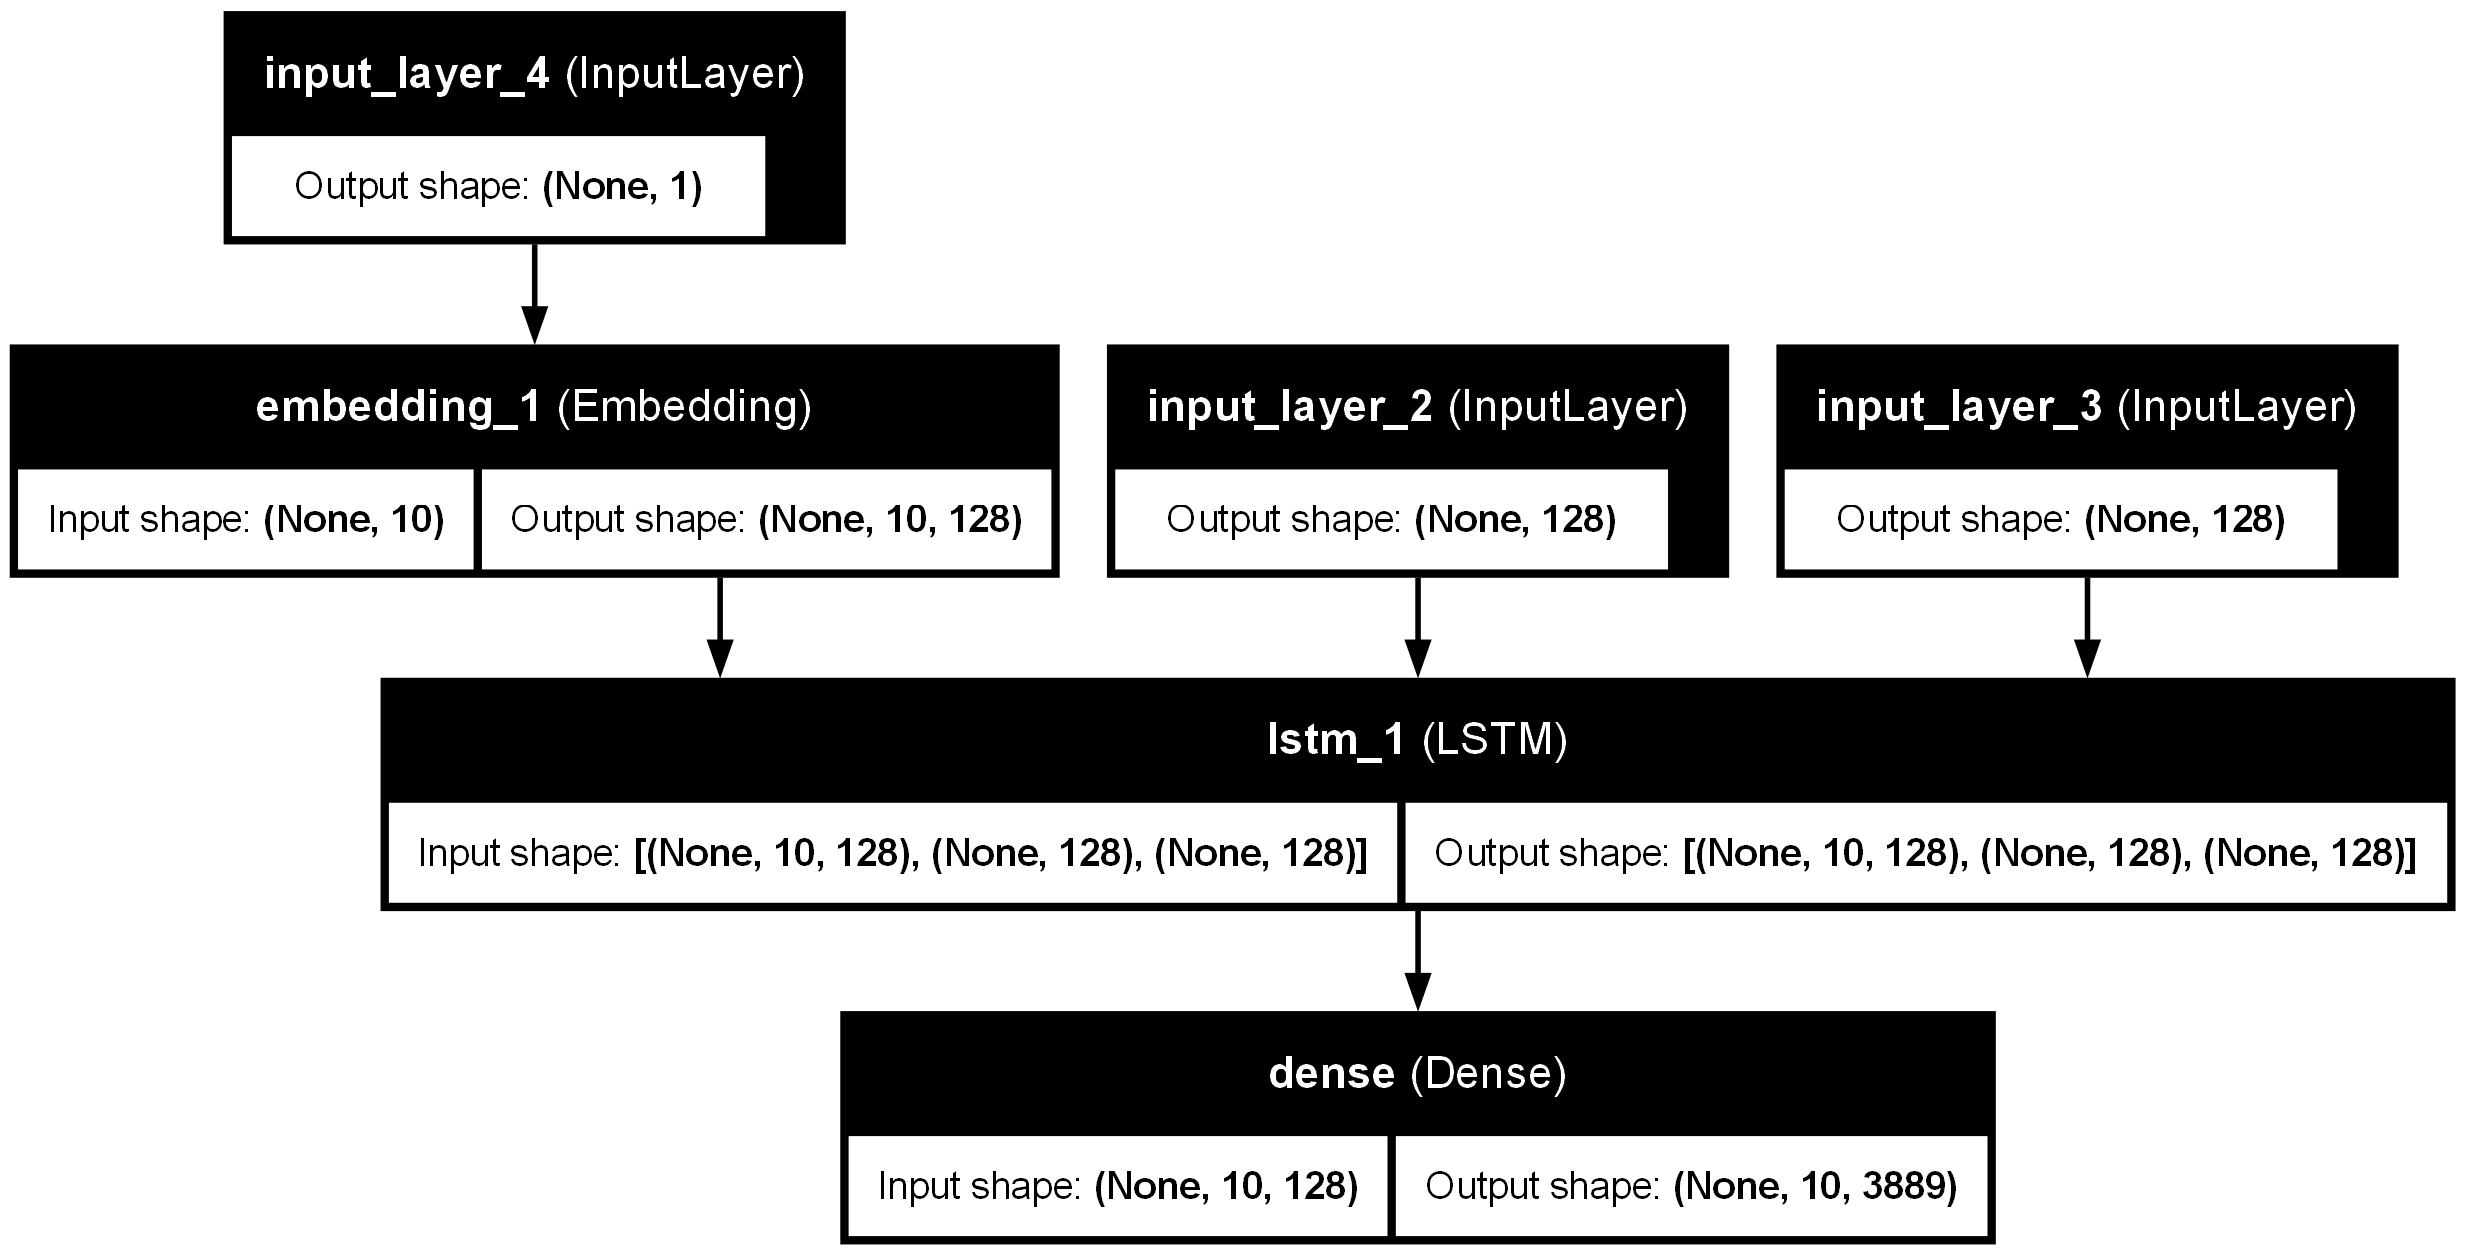

In [35]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file=PLOT_DECODER_PATH, show_shapes=True, show_layer_names=True)

*Una vez definido todo el pipeline, entrenamos el modelo:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Funciones auxiliares de ModelCkeckpiont y EarlyStopping</p></font></em>

In [36]:
# https://colab.research.google.com/github/Yash0330/Callbacks-in-Keras/blob/master/Introduction_to_callbacks.ipynb#scrollTo=eYmz1U150crs       
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  # Detiene el entrenamiento si no mejora
    restore_best_weights=True,  # Restaura los mejores pesos al final del entrenamiento
)

*Entrenamos el modelo:*

In [40]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15, 
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.5628 - loss: 2.5076 - val_accuracy: 0.6095 - val_loss: 2.4064
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6187 - loss: 2.2042 - val_accuracy: 0.6333 - val_loss: 2.2792
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6420 - loss: 2.0533 - val_accuracy: 0.6465 - val_loss: 2.1904
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6577 - loss: 1.9225 - val_accuracy: 0.6573 - val_loss: 2.1264
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6746 - loss: 1.8166 - val_accuracy: 0.6633 - val_loss: 2.0820
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.6740 - loss: 1.7833 - val_accuracy: 0.6668 - val_loss: 2.0508
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6866 - loss: 1.6871 - val_accuracy: 0.6687 - val_loss: 2.0268
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.6888 - loss: 1.6541 - 

*Graficamos los resultados:*

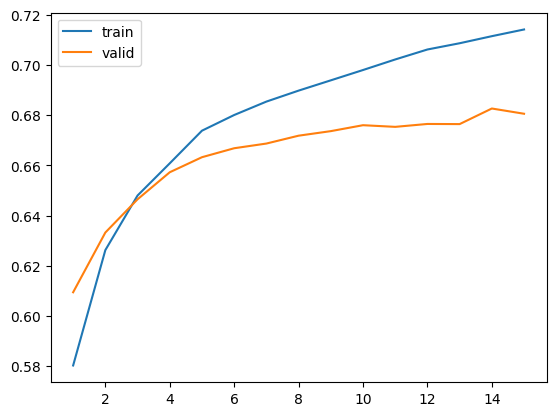

In [41]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Parte 5

> Experimentar el modelo en inferencia.

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>En tiempo de inferencia, se utiliza el "decoder" para este proceso. Sin embargo, se utiliza la primera entrada del decoder para pasarle el primer estado oculto; y luego el mismo "decoder" funciona autoregresivamente para el resto de los tokens, pasandole el nuevo estado oculto $(H, C)$ y la última salida del encoder, que en arquitecturas LSTM es la misma que $H$</p></font></em>

*Armamos los conversores de índices a palabras:*

In [43]:
# Armar los conversores de índice a palabra:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

*Creamos una función para realizar predicciones:*

In [51]:
def generate_response(input_seq):
    # El primer paso es obtener los estados ocultos del encoder.
    # Para esto, pasamos la entrada por el encoder:
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs[str(LABEL_SOS.strip())]

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs[str(LABEL_EOS.strip())]

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ""
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return " ".join(output_sentence)

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Dada una secuencia de tokens, devuelve sus términos:</p></font></em>

In [87]:
def build_sentence_from_tokens(token_seq, idx2word_input, idx2word_target):
    output_sentence = []
    for idx in token_seq:
        # Transformar idx a palabra
        word = ""
        if idx > 0:
            word = idx2word_input[idx] if idx2word_input else idx2word_target[idx]
            output_sentence.append(word)

    return " ".join(output_sentence)

In [90]:
build_sentence_from_tokens(encoder_input_sequences[10], idx2word_input, None)

'i am from the united states'

*Probamos 10 predicciones de nuestro conjunto de test:*

In [93]:
# Seleccionamos índices aleatorios
random_indices = random.sample(range(len(encoder_input_sequences)), 10)

# Creamos una lista para almacenar los datos
df_data = []

# Recorremos los índices aleatorios y creamos un diccionario para cada uno
for idx in random_indices:
    df_row = {
        "Indice": idx,
        "Input": build_sentence_from_tokens(encoder_input_sequences[idx], idx2word_input, None),
        "Response true": build_sentence_from_tokens(output_integer_seq[idx], None, idx2word_target),
        # Hay que expandir la primera dimensión, ya que la entrada debe ser (1,9) y encoder_input_sequences[i] es (9,)
        "Response generador": generate_response(np.expand_dims(encoder_input_sequences[idx], axis=0))
    }
    df_data.append(df_row)

# Creamos el DataFrame con los datos
df = pd.DataFrame(df_data)

# Mostramos el DataFrame
display(HTML(df.to_html()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

,Indice,Input,Response true,Response generador
0,5925,unknown,oh so what do you do for fun <eos>,i love to read
1,3150,hi there how are you,fine <eos>,i am a teacher i am a vegan
2,1139,which city,what do you do for a living <eos>,i am a teacher i am a vegan
3,750,bye,i traveled the americas playing guitar <eos>,i love to read
4,3733,hello i am beth how are you,fine <eos>,i am a teacher i am a vegan
5,4741,no problem do you have any hobbies,everything <eos>,i am a teacher i am a vegan
6,1307,hello how are you,i am doing well how are you <eos>,i am a teacher i am a vegan
7,3814,do you have any hobbies rob is my favorite,i like dancing and going out with friends <eos>,i like to read
8,1654,i m an economics major,that is cool i work at the animal shelter <eos>,i am a teacher i am a vegan
9,6227,how and why retired,mine 18 <eos>,i am a teacher i am a vegan


*Probamos con una consulta al azar nunca vista por el modelo:*

In [94]:
input_test = "the ring must be destroyed."
print("Input:", input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print("Input:", input_test)
translation = generate_response(encoder_sequence_test)
print("Response:", translation)

Input: the ring must be destroyed.
Representacion en vector de tokens de ids [18, 440, 71]
Padding del vector: [[  0   0   0   0   0   0  18 440  71]]
Input: the ring must be destroyed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Response: i am a teacher i am a vegan


⭐ <em><strong>Conclusión</strong></em> ⭐

<em><strong><p>Como conclusión general, podemos ver que el modelo es un buen generador del lenguaje, dado que las oraciones tienen coherencia. Sin embargo, no está solucionando el problema del dominio (BOT QA). Hay varios motivos... Uno es que claramente se podría entrenar por una mayor cantidad de épocas, dado que según los datos no había convergido aún. Por otro lado, no se llegó a un buen accuracy y el modelo empezó a overfittear, indicando necesidad de más datos o algún tipo de reguarización (no se utilizó ninguna).</p></strong></em>

⚠️ <em><font color='gold'>Problemas detectados:</font></em>
<em><font color='gold'><p>Un problema detectado es la cantidad de datos que hay que tener para que el modelo resuelva un problema específico, si se parte de un modelo de 0.</p></font></em>

💫 <em><font color='MediumPurple'> Mejoras posibles: </font></em>
<em><font color='MediumPurple'><p>

Se plantean varias mejoras:

1. Aplicar algún tipo de regularización (dropout o L2).
2. Probar más capas LSTM o cambiar la cantidad de neuronas.
3. Investigar el tamaño de contexto máximo, probar con varios hiperparámetros.
4. Dado que estamos en un mismo dominio, el tokenizador puede ser uno solo, en vez de utilizar dos (uno para la entrada del $Encoder$ y otro para la entrada-salida del $Decoder$)
5. En este caso, la capa de embedding del decoder se aprendió en etapa de aprendizaje. Habría que probar utilzar también FastText o GloVe para esta capa.

</p></font></em>